In [11]:
!pip install langchain_groq langchain_community langgraph langchain_core duckduckgo-search wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=6a70e14183db7c36d7acadcf98d4ab4574a8d33f7100c8c0c03f17127645850b
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
import time
import re
import requests
from bs4 import BeautifulSoup
import threading
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

True

   ### Defining states and llm

1. topic: the topics we want to research
2. wiki_queries: generated wikipedia queries for the given topic
3. search_queries: generated search queries for the given topic
4. search_results: combined search results of the search_queries
5. wiki_results: combination of all the fetched wikipedia articles
6. compilation: combined text blob of all the fetched data  
7. response: generated report for the topic with the given compilation of fetched data

In [3]:
class State(TypedDict):
    topic: str
    wiki_queries: Annotated[List[str], operator.add]
    search_queries: Annotated[List[str], operator.add]
    search_results: str
    wiki_results: str
    compilation: str
    response: str

# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)


### Using the inbuilt tools of langChain

In [4]:
# Initialize tools
search_tool = DuckDuckGoSearchRun()
wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(
        doc_content_chars_max=3000,
        top_k_results=5
    )
)

### Creating the search tool with fallback logic

In [5]:
def search_bing(query: str) -> List[str]:
    """Enhanced search with multiple fallbacks"""
    print(f"-Searching for: {query}")

    # First try DuckDuckGo
    try:
        print("Trying DuckDuckGo...")
        ddg_result = search_tool.run(query)
        if ddg_result and len(ddg_result.strip()) > 20:
            print(f"DuckDuckGo success: {len(ddg_result)} chars")
            return [f"DuckDuckGo Search Results for '{query}':\n{ddg_result}"]
    except Exception as e:
        print(f"DuckDuckGo failed: {str(e)[:100]}")

    # Fallback to Bing scraping
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    try:
        print("Trying Bing scraping...")
        url = f"https://www.bing.com/search?q={requests.utils.quote(query)}"
        resp = requests.get(url, headers=headers, timeout=10)

        if resp.status_code == 200:
            soup = BeautifulSoup(resp.text, "html.parser")
            results = []

            # Trying to find search results
            for item in soup.select("li.b_algo, .b_algo")[:3]:
                title_elem = item.select_one("h2 a, h2")
                snippet_elem = item.select_one(".b_caption p, p")

                if title_elem and snippet_elem:
                    title = title_elem.get_text(strip=True)
                    snippet = snippet_elem.get_text(strip=True)
                    if title and snippet:
                        results.append(f"Title: {title}\nSnippet: {snippet}")

            if results:
                print(f"Bing scraping success: {len(results)} results")
                return results

        print(f"Bing returned status: {resp.status_code}")

    except Exception as e:
        print(f"Bing scraping failed: {str(e)[:100]}")

    # Final fallback - return a placeholder
    print("All search methods failed")
    return [f"Search attempted for '{query}' but no results retrieved from available sources."]

## Defining the main nodes of the graph

1. generate_search_queries: it generates search queries in a list format using llm
2. generate_wiki_queries: it generates wikipedia article titles using llm
3. run_search_tool: it fetched search results using the search tool and combines them and updates the search_result state
4. run_wiki_tool: it fetched wikipedia articles using the wikipedia tool and combines them and updates the wiki_result state
5. compile_results: it combines all the fetched data and updates the compilation state with the data
6. generate_report: with the fetched data it generates a research report with llm

In [6]:
def generate_search_queries(state: State) -> dict:
    print("\n=== GENERATING SEARCH QUERIES ===")
    prompt = ChatPromptTemplate.from_template(
        "Generate 20 short, specific search queries for researching: {topic}\n"
        "Each query should be 5-10 words maximum, no descriptions.\n"
        "Format as simple numbered list:\n"
        "1. short query here\n"
        "2. another short query\n"
        "Examples:\n"
        "1. AI breakthroughs 2024\n"
        "2. machine learning advances\n"
        "3. AI healthcare applications"
    )
    chain = prompt | llm
    raw = chain.invoke({"topic": state["topic"]}).content

    # Clean query extraction
    queries = []
    for line in raw.split("\n"):
        line = line.strip()
        if not line:
            continue
        # Match numbered items only
        if re.match(r'^\d+\.?\s+', line):
            query = re.sub(r'^\d+\.?\s+', '', line).strip()
            # Remove quotes and descriptions
            query = query.split(' - ')[0].strip('"\'')
            if query and len(query.split()) <= 8:  # Max 8 words
                queries.append(query)

    print(f"Generated {len(queries)} clean search queries: {queries}")
    return {"search_queries": queries}

In [7]:
def generate_wiki_queries(state: State) -> dict:
    print("\n=== GENERATING WIKIPEDIA QUERIES ===")
    prompt = ChatPromptTemplate.from_template(
        "Generate 10-20 short Wikipedia article titles for: {topic}\n"
        "Use simple, direct titles that likely exist on Wikipedia.\n"
        "Format as numbered list:\n"
        "1. Article Title One\n"
        "2. Article Title Two\n"
        "Examples:\n"
        "1. Artificial Intelligence\n"
        "2. Machine Learning\n"
        "3. Natural Language Processing"
    )
    chain = prompt | llm
    raw = chain.invoke({"topic": state["topic"]}).content

    # Clean title extraction
    titles = []
    for line in raw.split("\n"):
        line = line.strip()
        if not line:
            continue
        if re.match(r'^\d+\.?\s+', line):
            title = re.sub(r'^\d+\.?\s+', '', line).strip()
            # Remove quotes and extra descriptions
            title = title.split(' - ')[0].strip('"\'')
            if title and len(title) < 50:  # Reasonable length
                titles.append(title)

    print(f"Generated {len(titles)} Wikipedia titles: {titles}")
    return {"wiki_queries": titles}

In [8]:
def run_search_tool(state: State) -> dict:
    print("\n=== EXECUTING WEB SEARCH ===")
    print(f"Search queries to process: {state.get('search_queries', [])}")

    all_results = []  # Using list to accumulate results

    for i, query in enumerate(state.get('search_queries', []), 1):
        print(f"Processing search query {i}/{len(state.get('search_queries', []))}: {query}")
        try:
            results = search_bing(query)
            if results:
                all_results.extend(results)  # Add all results from this query
                print(f"Added {len(results)} results from query: {query}")
            else:
                print(f"No results for query: {query}")

            time.sleep(1)  # Adding a time delay to prevent DuckDuckGo rate limiting
        except Exception as e:
            print(f"Error searching '{query}': {str(e)}")

    # Joining all results into a single string
    search_results_text = "\n\n=== SEARCH RESULT ===\n".join(all_results) if all_results else "No search results found."
    print(f"Total search results collected: {len(all_results)} items ({len(search_results_text)} chars)")

    return {"search_results": search_results_text}

In [9]:

def run_wiki_tool(state: State) -> State:
    print("\n=== EXECUTING WIKIPEDIA SEARCH ===")
    print(f"Wikipedia queries to process: {state.get('wiki_queries', [])}")
    all_results = []  # Using list to accumulate results
    
    def fetch_with_timeout(title: str, timeout: int = 20):
        """Fetch Wikipedia content with timeout using threading"""
        result = None
        exception = None
        
        def target():
            nonlocal result, exception
            try:
                result = wikipedia.invoke(title)
            except Exception as e:
                exception = e
        
        thread = threading.Thread(target=target)
        thread.daemon = True  # Dies when main thread dies
        thread.start()
        thread.join(timeout)
        
        if thread.is_alive():
            # Thread is still running, it timed out
            print(f"Wikipedia search timed out for '{title}' ({timeout} seconds)")
            return None, "timeout"
        elif exception:
            return None, str(exception)
        else:
            return result, None
    
    for i, title in enumerate(state.get("wiki_queries", []), 1):
        print(f"Fetching Wikipedia ({i}/{min(5, len(state.get('wiki_queries', [])))}): {title}")
        
        try:
            result, error = fetch_with_timeout(title, 20)
            
            if error == "timeout":
                all_results.append(f"=== WIKIPEDIA TIMEOUT: {title} ===\nSearch timed out after 20 seconds")
                print(f"Moving to next query after timeout...")
                
            elif error:
                print(f"Wikipedia error for '{title}': {error}")
                all_results.append(f"=== WIKIPEDIA ERROR: {title} ===\nError: {error[:200]}")
                
            elif result and result.strip():
                all_results.append(f"=== WIKIPEDIA: {title} ===\n{result}")
                print(f"Wikipedia content fetched for: {title} ({len(result)} chars)")
                
            else:
                print(f"No Wikipedia content for: {title}")
                all_results.append(f"=== WIKIPEDIA: {title} ===\nNo content found")
            
            # Always sleep between requests to prevent rate limiting
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Unexpected error for '{title}': {str(e)}")
            all_results.append(f"=== WIKIPEDIA ERROR: {title} ===\nUnexpected error: {str(e)[:200]}")
    
    # Joining all results into a single string
    wiki_results_text = "\n\n".join(all_results) if all_results else "No Wikipedia results found."
    print(f"Total Wikipedia results: {len(all_results)} items ({len(wiki_results_text)} chars)")
    print("=== WIKIPEDIA SEARCH COMPLETED ===\n")
    
    return {"wiki_results": wiki_results_text}


def compile_results(state: State) -> dict:
    print("\n=== COMPILING RESULTS ===")
    sections = []

    # Adding search results
    if state.get('search_results') and state['search_results'].strip():
        sections.append("# Web Search Results\n")
        sections.append(state['search_results'])
        print(f"Added search results ({len(state['search_results'])} chars)")
    else:
        print("No search results to compile")

    # Adding Wikipedia results
    if state.get('wiki_results') and state['wiki_results'].strip():
        sections.append("\n\n# Wikipedia Results\n")
        sections.append(state['wiki_results'])
        print(f"Added Wikipedia results ({len(state['wiki_results'])} chars)")
    else:
        print("No Wikipedia results to compile")

    compilation = "\n".join(sections) if sections else "No content available for compilation."
    print(f"Compilation complete: {len(compilation)} chars")

    return {"compilation": compilation}

def generate_report(state: State) -> dict:
    print("\n=== GENERATING REPORT ===")

    if not state.get('compilation') or len(state['compilation'].strip()) < 50:
        return {"response": "Unable to generate report: Insufficient source material collected."}

    prompt = ChatPromptTemplate.from_template(
        "Create a comprehensive professional research report based on the following information:\n\n"
        "{data}\n\n"
        "Report Structure:\n"
        "# [Topic Title]\n"
        "**Date:** {date}\n\n"
        "## Executive Summary\n"
        "[2-3 paragraph overview of key findings]\n\n"
        "## Introduction\n"
        "[Background and context]\n\n"
        "## Key Findings\n"
        "[Main discoveries and facts organized by themes]\n\n"
        "## Analysis\n"
        "[Detailed examination of important aspects]\n\n"
        "## Current Developments\n"
        "[Recent trends and updates]\n\n"
        "## Implications\n"
        "[Significance and impact]\n\n"
        "## Conclusion\n"
        "[Summary and future outlook]\n\n"
        "Guidelines:\n"
        "- Write in formal, professional tone\n"
        "- Minimum 1200-1500 words (2 full pages)\n"
        "- Use detailed analysis and comprehensive coverage\n"
        "- Include specific facts, statistics, and examples from the source material\n"
        "- Ensure each section is substantive with multiple paragraphs\n"
        "- No promotional language or unnecessary adjectives\n"
        "- Add proper lines with '\n' \n"
        "- Focus on factual content and objective analysis"
    )

    try:
        chain = prompt | llm
        report = chain.invoke({
            "data": state['compilation'],
            "date": datetime.now().strftime("%Y-%m-%d")
        }).content

        print(f"Report generated successfully ({len(report)} chars)")
        return {"response": report}
    except Exception as e:
        print(f"Report generation failed: {str(e)}")
        return {"response": f"Report generation failed: {str(e)}\n\nRaw compilation data:\n{state.get('compilation', 'No data available')[:4000]}..."}



## Creating the workflow and adding the nodes and edges

In [10]:
# Create the workflow
workflow = StateGraph(State)

# === NODES ===
workflow.add_node("gen_search_qs", generate_search_queries)
workflow.add_node("run_search", run_search_tool)
workflow.add_node("gen_wiki_qs", generate_wiki_queries)
workflow.add_node("run_wiki", run_wiki_tool)
workflow.add_node("join", lambda state: state)  # Simple join node
workflow.add_node("compile", compile_results)
workflow.add_node("report", generate_report)

# === ENTRY POINT ===
workflow.set_entry_point("gen_search_qs")

# === EDGES ===
# After generating search queries, branch to both search execution and wiki query generation
workflow.add_edge("gen_search_qs", "run_search")
workflow.add_edge("gen_search_qs", "gen_wiki_qs")  # Parallel execution

# Both search paths converge at join
workflow.add_edge("run_search", "join")
workflow.add_edge("gen_wiki_qs", "run_wiki")
workflow.add_edge("run_wiki", "join")

# Final path
workflow.add_edge("join", "compile")
workflow.add_edge("compile", "report")
workflow.add_edge("report", END)

# Compile the workflow
app = workflow.compile()

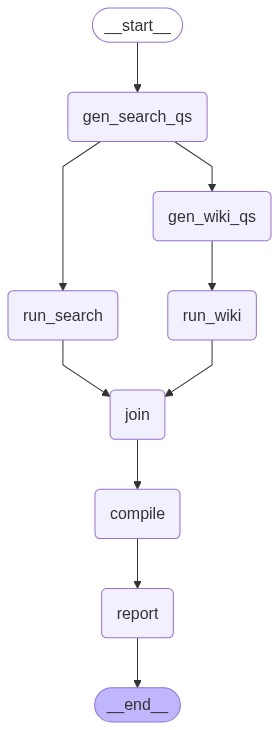

In [11]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

## Testing the Agent

In [38]:
# Example usage
if __name__ == "__main__":
    try:
        print("Starting Research Agent...")

        # Test with a simpler topic first
        test_topics = [
            "pahalgam-india attack",
            "pahalgam attack",
            "indian military on pahalgam attack",
            "pahalgam terror attack "
        ]

        topic = test_topics[0]
        print(f"Researching: {topic}")

        output = app.invoke({"topic": topic})

        print("\n" + "="*50)
        print("FINAL REPORT")
        print("="*50)

        if output.get("response"):
            print(output["response"])
        else:
            print("No report generated")

        # Debug information
        print(f"\nDebug Info:")
        print(f"Search queries: {output.get('search_queries', [])}")
        print(f"Wiki queries: {output.get('wiki_queries', [])}")
        print(f"Search results length: {len(output.get('search_results', ''))}")
        print(f"Wiki results length: {len(output.get('wiki_results', ''))}")
        print(f"Compilation length: {len(output.get('compilation', ''))}")

    except Exception as e:
        print(f"Execution failed: {str(e)}")
        import traceback
        traceback.print_exc()

🚀 Starting Research Agent...
🎯 Researching: pahalgam-india attack

=== GENERATING SEARCH QUERIES ===
Generated 20 clean search queries: ['Pahalgam India terrorist attack', 'Pahalgam militant attack', 'India Pahalgam violence', 'Pahalgam attack news', 'Pahalgam India clashes', 'Pahalgam militant strikes', 'Pahalgam India unrest', 'Pahalgam attack updates', 'Pahalgam India insurgency', 'Pahalgam violence reports', 'Pahalgam India conflict', 'Pahalgam attack victims', 'Pahalgam India security', 'Pahalgam militant groups', 'Pahalgam India blasts', 'Pahalgam attack investigation', 'Pahalgam India curfew', 'Pahalgam violence toll', 'Pahalgam India protests', 'Pahalgam attack aftermath']

=== GENERATING WIKIPEDIA QUERIES ===

=== EXECUTING WEB SEARCH ===
Search queries to process: ['Pahalgam India terrorist attack', 'Pahalgam militant attack', 'India Pahalgam violence', 'Pahalgam attack news', 'Pahalgam India clashes', 'Pahalgam militant strikes', 'Pahalgam India unrest', 'Pahalgam attack upd